In [7]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data
For more details on how data is loaded, please see `subroutines.py`.

In [8]:
def return_HM_npy(csvfile_path):
    Hs = []
    Ms = []
    with open(csvfile_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # Skipping the header
        for row in reader:
            Hs.append(float(row[0]))
            Ms.append(float(row[1]))
    return np.array(Hs), np.array(Ms)

def accept_test_middle(H, M, noise_std=0.01, f=None):
    noise = abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else:
        return False

def generate_training_data(noise_std=0.004, data_size=10000, Hrange=[0, 0.022], Mrange=[0, 0.11], f=None):
    H_pos_data = []
    M_pos_data = []
    F_pos_data = []
    #
    H_neg_data = []
    M_neg_data = []
    F_neg_data = []
    #
    while True:
        H = np.random.uniform(Hrange[0], Hrange[1])# sampling from uniform distribution.
        M = np.random.uniform(Mrange[0], Mrange[1]) 
        if accept_test_middle(H, M, noise_std, f) and len(F_pos_data)<data_size:
            H_pos_data.append([H])
            M_pos_data.append([M])
            F_pos_data.append([0])
        elif len(F_neg_data)<data_size:
            H_neg_data.append([H])
            M_neg_data.append([M])
            F_neg_data.append([1])
        if len(F_pos_data)==data_size and len(F_neg_data)==data_size:
            break
    return (np.array(H_pos_data), np.array(M_pos_data), np.array(F_pos_data)), (np.array(H_neg_data), np.array(M_neg_data), np.array(F_neg_data))

def plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f):
    plt.xlabel('quark mass [GeV]', fontsize=18)
    plt.ylabel(r'$\langle\bar{q}q\rangle$ [GeV$^3$]', fontsize=18)
    #
    plt.plot(positive_H_M_F[0], positive_H_M_F[1], 'b.', label='positive', alpha=0.3)
    plt.plot(negative_H_M_F[0], negative_H_M_F[1], 'g.', label='negative', alpha=0.3)
    hs = np.linspace(np.min(Hs), np.max(Hs), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(Hs, Ms, 'ro', label='data')
    plt.legend(loc='upper right',
               bbox_to_anchor=(1.05, 0.5, 0.5, .100), )
    plt.show()

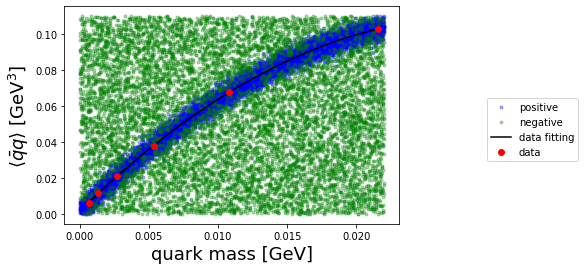

In [9]:
# data values
Hs, Ms = return_HM_npy('q-pp-highT-phys.csv') # data
# data fitting
f = np.poly1d(np.polyfit(Hs, Ms, deg=3)) # data fitting
# data augmentation (H_M_F = (x, y, 0/1) )
positive_H_M_F, negative_H_M_F = generate_training_data(data_size=10000, f=f)
# plot
plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [10]:
class Phi_Pi_DataSet(Dataset):
    ''' class for handling data '''
    def __init__(self, positive_H_M_F, negative_H_M_F, transform=None):
        self.phi = np.concatenate((positive_H_M_F[0], negative_H_M_F[0]),axis=0).astype(np.float32)
        self.Pi = np.concatenate((positive_H_M_F[1], negative_H_M_F[1]),axis=0).astype(np.float32)
        self.ans = np.concatenate((positive_H_M_F[2], negative_H_M_F[2]),axis=0).astype(np.float32)
        self.transform = transform

    def __getitem__(self, index):
        phi = self.phi[index]
        Pi = self.Pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi = self.transform(phi)
            Pi = self.transform(Pi)
            ans = self.transform(ans)
        return phi, Pi, ans

    def __len__(self):
        return len(self.phi)

In [11]:
train_d_loader = DataLoader(Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=1000, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [12]:
# def phi_one_step(phi=None, Pi=None, del_eta=None):
#     ''' phi's eta evolution '''
#     return phi + del_eta*Pi 

# def Pi_one_step(phi=None, Pi=None, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Pi's eta evolution '''
#     return Pi +(-1)*del_eta*(Pi_W - phi_m2 - phi3_lam)

# def one_step(phi, Pi, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Evolutions both phi and Pi '''
#     phi2 = phi_one_step(phi, Pi, del_eta)
#     Pi2 = Pi_one_step(phi, Pi, Pi_W=Pi_W, phi_m2=phi_m2, phi3_lam = phi3_lam, del_eta=del_eta)
#     return phi2, Pi2

def onestep(phi, Pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*Pi
    Pi1 = phi*m2*del_eta + (1-del_eta*hh)*Pi + del_eta*lamb*(phi1**3)
    return phi1, Pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, Pi, eta=None):
    ''' returning Pi'''
    F=Pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)

##### 

class MetricNet(nn.Module):
    ''' class of model to be trained '''
    def __init__(self, Number_of_layers=None, eta_ini=None, eta_fin=None, m2=None, del_eta=None, d=None):
        super(MetricNet, self).__init__()
        # trained parameters
        Hs = []
        for layer_index in range(Number_of_layers):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs = nn.ModuleList(Hs)
        self.adsradius = nn.Linear(1, 1, bias=False)
        self.lamb = nn.Linear(1, 1, bias=False)
        # fixed parameters
        self.one = Variable(torch.ones(1)) # it would be better to use torch.nn.parameter.
        self.N_layers = Number_of_layers
        self.eta_ini = eta_ini
        self.eta_fin = eta_fin
        self.m2 = m2
        self.del_eta = del_eta
        self.d = d

    def show_lamb(self):
        return self.lamb(self.one)
    
    def show_adsradius(self):
        return self.adsradius(self.one)
        
    def penalty(self, coef_list=None):
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layers))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        for i in range(self.N_layers):
            H = self.Hs[i]
            if H==self.Hs[0]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = 0.01*(self.d - H(self.one))**2
                pH = H(self.one)
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
        
    def forward(self, phi=None, Pi=None):
        ''' forward propagation '''
        # initial layer
        alphatilde = self.adsradius(self.one)*(1.7320508/(2*3.1415926))*phi
        betatilde = (self.adsradius(self.one))**3*(3.1415926/1.7320508)*Pi
        phi = alphatilde*(np.exp(-self.eta_ini)) + betatilde*(np.exp(-3*self.eta_ini)) -(1/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))
        Pi = -alphatilde*(np.exp(-self.eta_ini)) -3*betatilde*(np.exp(-3*self.eta_ini)) +(3/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))-(1/2)*alphatilde**3*self.lamb(self.one)*(np.exp(-3*self.eta_ini))
        # intermediate layers
        for H in self.Hs:
            phi, Pi = onestep(phi, Pi, hh=H(self.one), m2=self.m2, lamb=self.lamb(self.one), del_eta=self.del_eta)
        # finaly layer
        f_ = f(phi, Pi, eta=eta(self.N_layers, self.eta_ini, self.eta_fin, self.N_layers))
        final = t(f_, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss(self, phi=None, Pi=None, answer=None, reg_coef_list=None):
        model_output = self.forward(phi=phi, Pi=Pi)
        loss = F.l1_loss(model_output, answer)**2
        loss = loss + self.penalty(coef_list=reg_coef_list)
        return loss

def init_weights(Model, d):
    ''' for initializations of parameters '''
    # metric (H[layer])
    for i in range(len(Model.Hs)):
        # ipt = initial value for H[i]
        ipt = d
        # noize 
        std = 3
        w = np.random.normal(ipt, std) # sampling from Gaussian
        w = round(w, 10) # it seems to be needed to round w somehow, I don't know why...
        Model.Hs[i].weight.data.fill_(w) # initialization excuted 
    
    # lambda
    lamb = 0.2
    std = 0
    lamb = np.random.normal(lamb, std)
    Model.lamb.weight.data.fill_(lamb)
    
    # AdS radius[GeV^{-1}]
    adsradius = 0.8
    std = 0
    adsradius = np.random.normal(adsradius, std)
    Model.adsradius.weight.data.fill_(adsradius)

In [20]:
# parameters
d = 4
m2 = -3 # mass^2
N_layer = 15
Delta_plus = d/2 +1
Delta_minus= d/2 -1
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
# making network
Test = MetricNet(Number_of_layers=N_layer, 
                         eta_ini=eta_ini, 
                         eta_fin=eta_fin,
                         m2=m2, 
                         del_eta=del_eta,
                         d=d)
init_weights(Test, d)
# setting it to be trained
optimizer = optim.Adam(Test.parameters()) 
Test.train()
# For regularization terms
regularization_coeffs = [0] #(np.array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])*0.001).tolist()
for i in range(1, N_layer):
    regularization_coeffs.append(0.01*eta(i, eta_ini, eta_fin, N_layer)**4)
print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
print("H: ", np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

lambda: 0.20000000298023224,   AdS radius: 0.800000011920929[1/GeV]
H:  [ 3.4662905  -1.4633311   1.986144    1.0711181   0.09464812  6.5027113
  0.5645767  -0.7766958  -2.0014985  -0.4154096  -0.07619455 10.837575
  8.195029   -1.1352339   5.467318  ]


# 3. Train your NN

In [21]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('quark mass [GeV]', fontsize=12)
    al.set_ylabel(r'$\langle \bar{q}q\rangle$ [GeV$^3$]', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='Positive')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(negative)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(positive)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layers,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

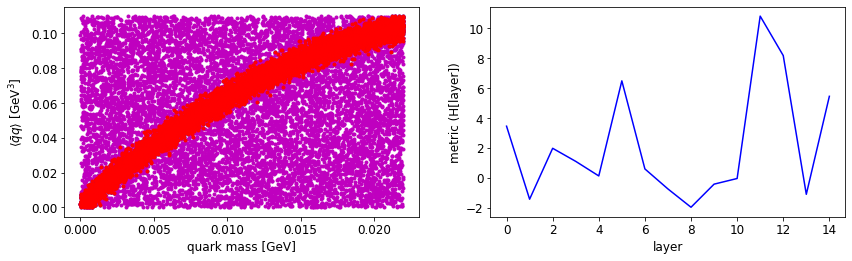

training epoch: 0,   loss: 0.8380653262138367
lambda: 0.2000076025724411,   AdS radius: 0.7863426208496094[1/GeV]
[ 3.446307   -1.4433423   1.9661642   1.0908315   0.11464193  6.482719
  0.5845671  -0.75669605 -1.981512   -0.43535367 -0.05620777 10.817579
  8.175047   -1.1152397   5.447326  ]


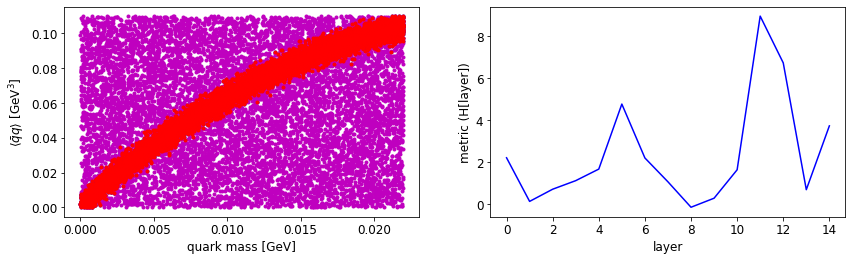

training epoch: 100,   loss: 0.3936636447906494
lambda: 0.2000269740819931,   AdS radius: 0.7366676330566406[1/GeV]
[ 2.2157671   0.13907322  0.71887237  1.1265888   1.6768023   4.772134
  2.2069886   1.0706646  -0.13932972  0.29041335  1.6439339   8.959046
  6.7329216   0.69663405  3.7343593 ]


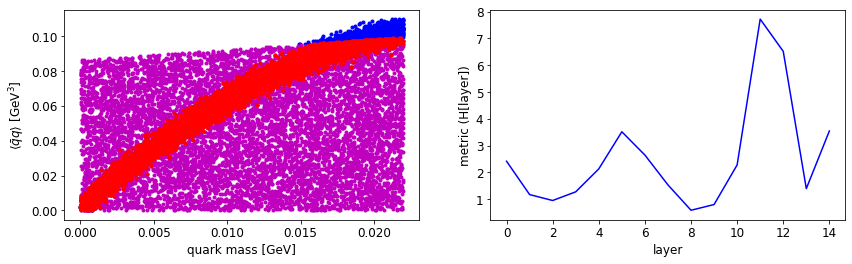

training epoch: 200,   loss: 0.29170891642570496
lambda: -0.37749189138412476,   AdS radius: 1.3768482208251953[1/GeV]
[2.4188173 1.1739122 0.9526881 1.2767918 2.1328542 3.5184565 2.6495407
 1.535773  0.5895645 0.8019543 2.281066  7.723005  6.5200295 1.3960751
 3.547595 ]


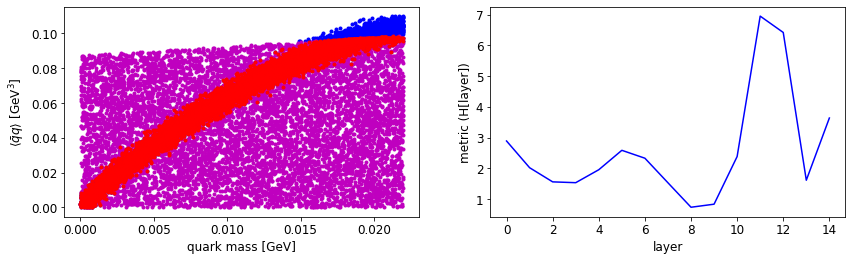

training epoch: 300,   loss: 0.2617102563381195
lambda: -1.097851276397705,   AdS radius: 1.306152582168579[1/GeV]
[2.8875086  2.017692   1.5567527  1.5300577  1.9517751  2.583995
 2.3268921  1.5266674  0.7305766  0.83013415 2.3816435  6.9530954
 6.420668   1.6104071  3.6354015 ]


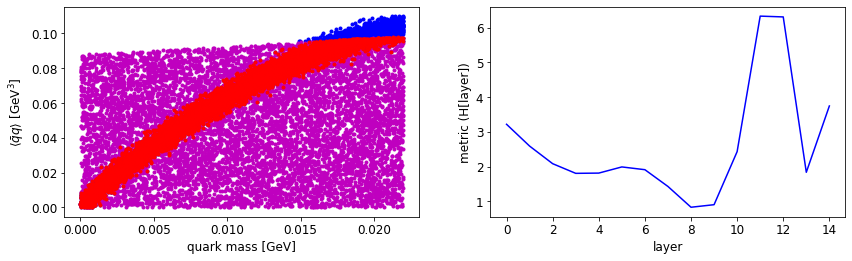

training epoch: 400,   loss: 0.24942965805530548
lambda: -1.796439528465271,   AdS radius: 1.2729922533035278[1/GeV]
[3.217544  2.5902019 2.0838597 1.805982  1.8132706 1.9905741 1.9111055
 1.4283696 0.830716  0.9040689 2.430728  6.3295975 6.3064203 1.836672
 3.7444777]


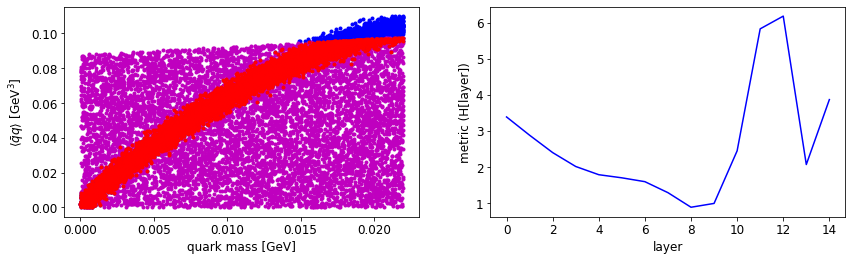

training epoch: 500,   loss: 0.24532508850097656
lambda: -2.5043625831604004,   AdS radius: 1.2668416500091553[1/GeV]
[3.3849947  2.8775566  2.3958845  2.0102415  1.7823459  1.6959978
 1.5891924  1.2843077  0.87972677 0.98580784 2.444861   5.8291163
 6.1822906  2.0648408  3.8663437 ]


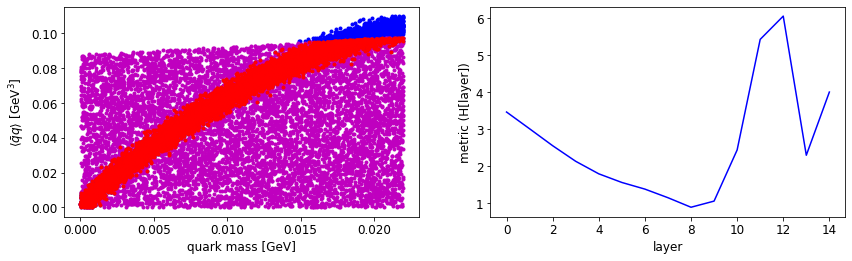

training epoch: 600,   loss: 0.24367287755012512
lambda: -3.235999822616577,   AdS radius: 1.2782965898513794[1/GeV]
[3.457606   3.0040135  2.5462792  2.1244414  1.7859241  1.552446
 1.3726815  1.1398855  0.88207144 1.0481278  2.4311779  5.4222236
 6.051729   2.2887151  3.9975388 ]


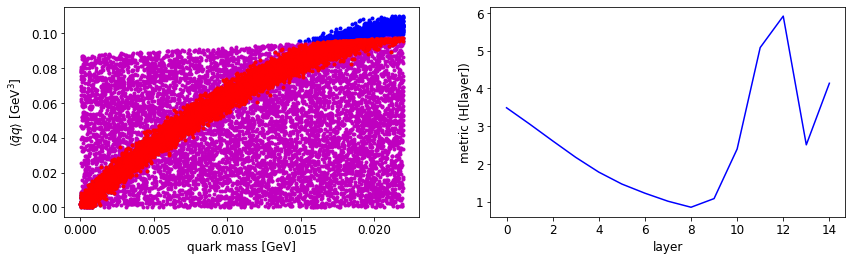

training epoch: 700,   loss: 0.24239401519298553
lambda: -4.000392913818359,   AdS radius: 1.3054864406585693[1/GeV]
[3.4873488 3.0562773 2.6100132 2.1735241 1.7818385 1.4657975 1.223175
 1.0106707 0.8506083 1.0797218 2.3939452 5.0834084 5.9175124 2.5056887
 4.1370673]


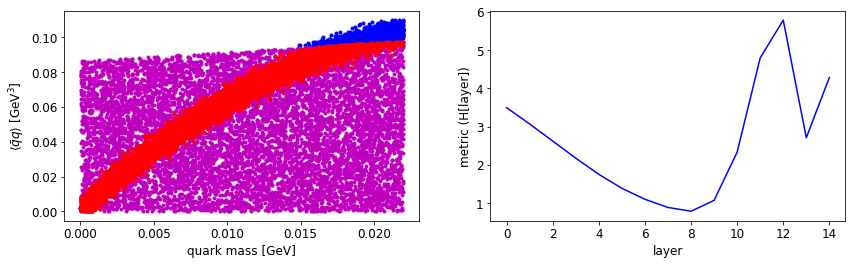

training epoch: 800,   loss: 0.24120402336120605
lambda: -4.812790870666504,   AdS radius: 1.352418065071106[1/GeV]
[3.4949183 3.0696597 2.6246068 2.1774476 1.7556341 1.3908405 1.1030556
 0.8905989 0.7911857 1.073987  2.332153  4.7927537 5.780165  2.709873
 4.2818933]


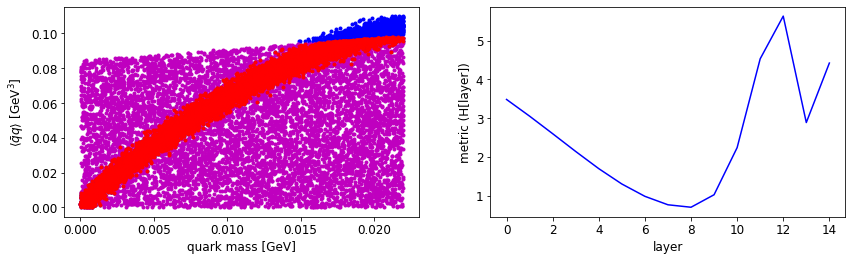

training epoch: 900,   loss: 0.23939132690429688
lambda: -5.699113368988037,   AdS radius: 1.4392879009246826[1/GeV]
[3.4837139  3.0516589  2.5985513  2.1385522  1.6949154  1.298489
 0.97951937 0.76090527 0.69730276 1.020568   2.2382796  4.5344625
 5.6381745  2.8870993  4.4245796 ]


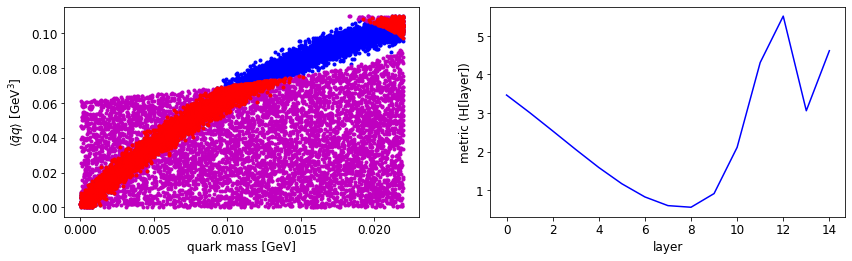

training epoch: 1000,   loss: 0.225110724568367
lambda: -6.762694358825684,   AdS radius: 1.8006420135498047[1/GeV]
[3.4648347  3.0104508  2.5346162  2.052422   1.5853297  1.1633239
 0.82136357 0.59584683 0.5538905  0.9085677  2.108242   4.3077283
 5.51244    3.057517   4.614616  ]


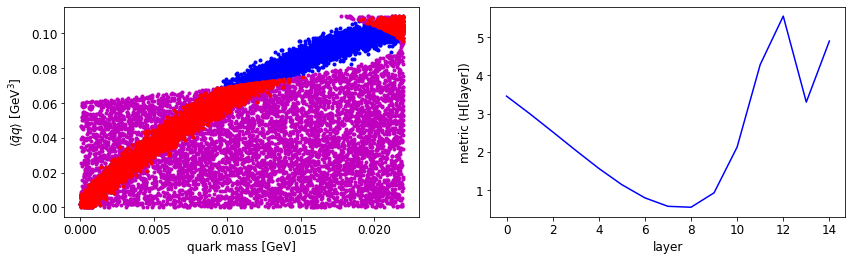

training epoch: 1100,   loss: 0.22425219416618347
lambda: -6.7524638175964355,   AdS radius: 1.8017363548278809[1/GeV]
[3.455097   2.9982326  2.5206692  2.035529   1.5644948  1.1379861
 0.79294616 0.57160956 0.5472988  0.9251911  2.1232293  4.279627
 5.5496407  3.298693   4.8969965 ]


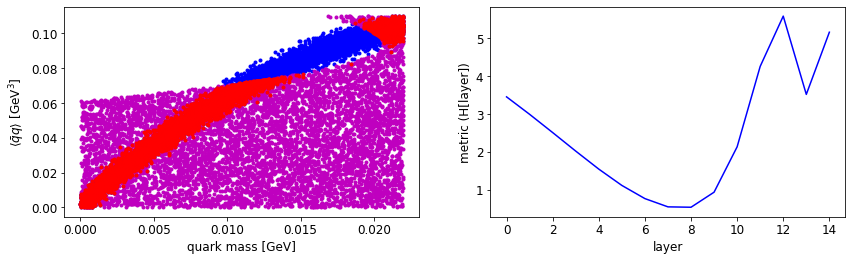

training epoch: 1200,   loss: 0.22390484809875488
lambda: -6.744725704193115,   AdS radius: 1.7993521690368652[1/GeV]
[3.4490442  2.9883578  2.5070186  2.0183957  1.5436851  1.1132915
 0.7657703  0.54779166 0.537638   0.93454224 2.1311698  4.2523007
 5.5782857  3.513811   5.153747  ]


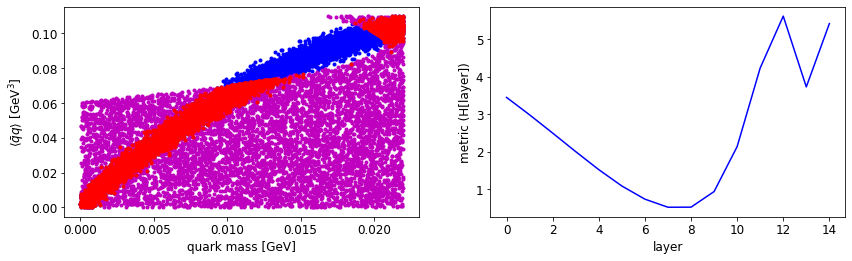

training epoch: 1300,   loss: 0.22325260937213898
lambda: -6.734591960906982,   AdS radius: 1.798280119895935[1/GeV]
[3.4473708  2.9836771  2.498586   2.0059144  1.5271331  1.0928677
 0.7430012  0.52793956 0.53028494 0.9442576  2.1395702  4.2292657
 5.607726   3.7264264  5.4086514 ]


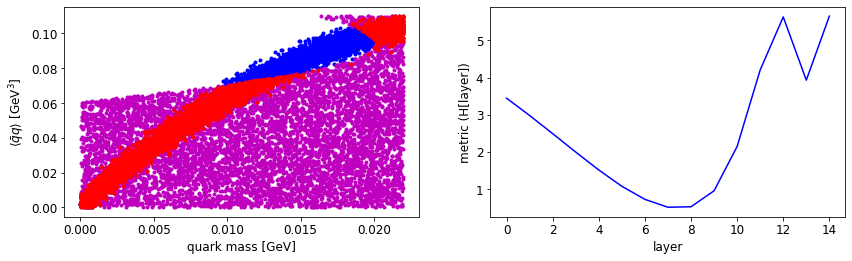

training epoch: 1400,   loss: 0.2226853370666504
lambda: -6.726594924926758,   AdS radius: 1.7963367700576782[1/GeV]
[3.444923   2.978906   2.4904268  1.9936438  1.5105265  1.0722587
 0.7200301  0.50740135 0.5207037  0.9498628  2.1438348  4.205439
 5.632985   3.9306085  5.655128  ]


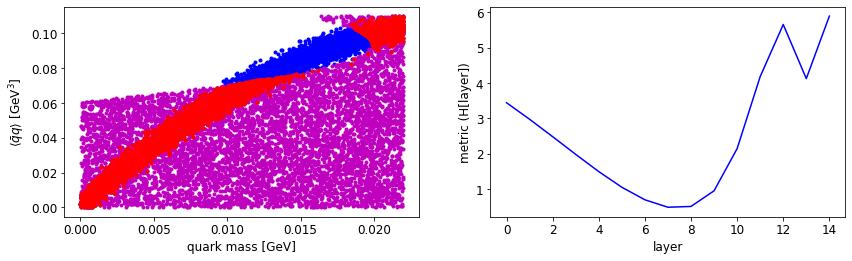

training epoch: 1500,   loss: 0.22249123454093933
lambda: -6.718310832977295,   AdS radius: 1.7955013513565063[1/GeV]
[3.4438994  2.9760377  2.4846025  1.983927   1.4964485  1.0541162
 0.6994532  0.48875877 0.5115382  0.9540064  2.1466227  4.183446
 5.656516   4.12697    5.893825  ]


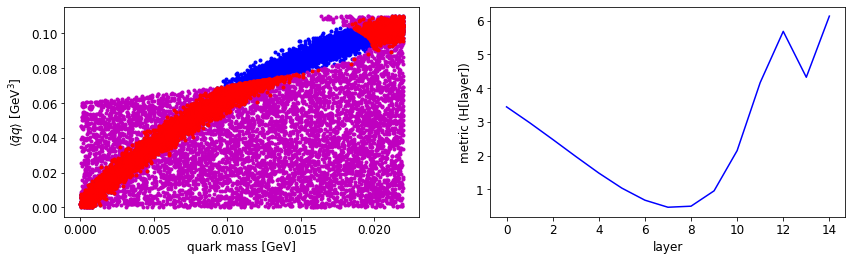

training epoch: 1600,   loss: 0.22200672328472137
lambda: -6.709392070770264,   AdS radius: 1.7939507961273193[1/GeV]
[3.443842  2.9745295 2.4804823 1.9761113 1.4842786 1.0377524 0.6804757
 0.4712768 0.5024452 0.9568544 2.1480415 4.162355  5.6789203 4.32037
 6.1304507]


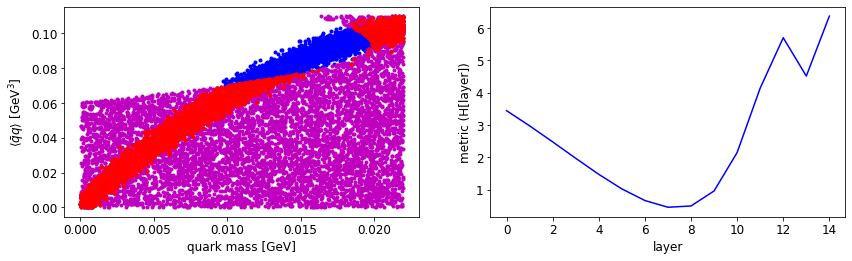

training epoch: 1700,   loss: 0.22171840071678162
lambda: -6.699938774108887,   AdS radius: 1.7910833358764648[1/GeV]
[3.4438732  2.973402   2.4770412  1.9691892  1.4730314  1.0221827
 0.66208357 0.45399314 0.49272364 0.95805454 2.1477644  4.141352
 5.700531   4.5144033  6.369646  ]


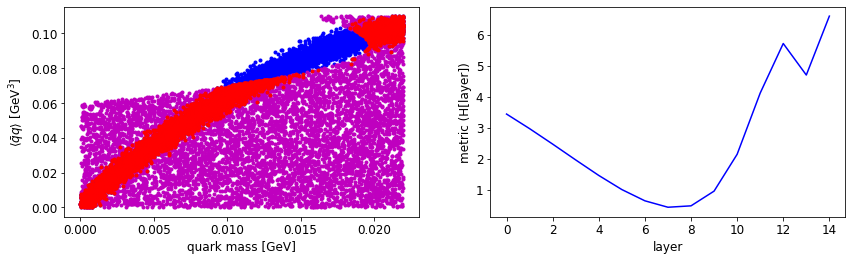

training epoch: 1800,   loss: 0.22130990028381348
lambda: -6.69172477722168,   AdS radius: 1.7913808822631836[1/GeV]
[3.4441     2.9726899  2.4742763  1.9631821  1.4628452  1.0076618
 0.64455557 0.437096   0.48234874 0.95728153 2.145413   4.1203794
 5.720147   4.7028847  6.603964  ]


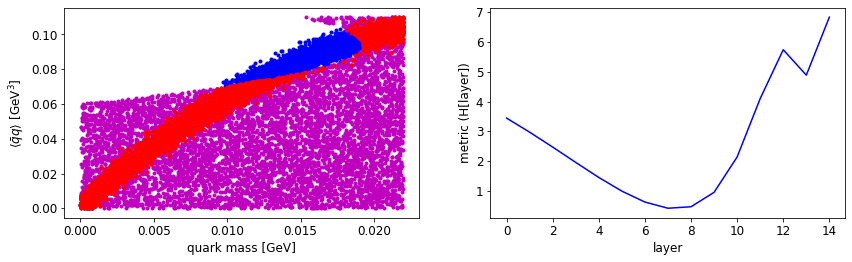

training epoch: 1900,   loss: 0.22106914222240448
lambda: -6.684080123901367,   AdS radius: 1.7885934114456177[1/GeV]
[3.4438617  2.9718416  2.471684   1.9576325  1.4533225  0.99386436
 0.6276102  0.4203212  0.47109294 0.9543415  2.140749   4.0990195
 5.737255   4.8842587  6.8314576 ]


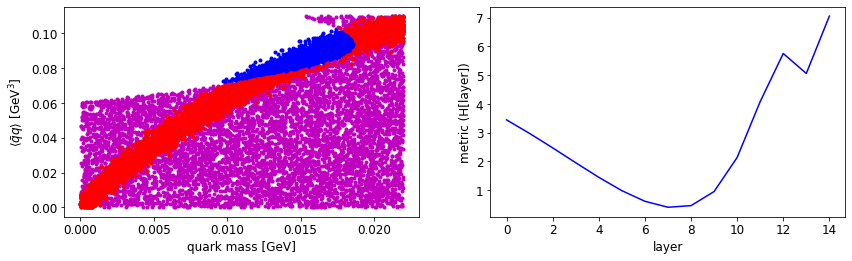

training epoch: 2000,   loss: 0.22073519229888916
lambda: -6.676751613616943,   AdS radius: 1.7850279808044434[1/GeV]
[3.4436781  2.9712894  2.4696918  1.9529883  1.4449517  0.9813323
 0.6118412  0.40430373 0.45967162 0.9500525  2.1346319  4.078015
 5.7526975  5.058642   7.0521936 ]


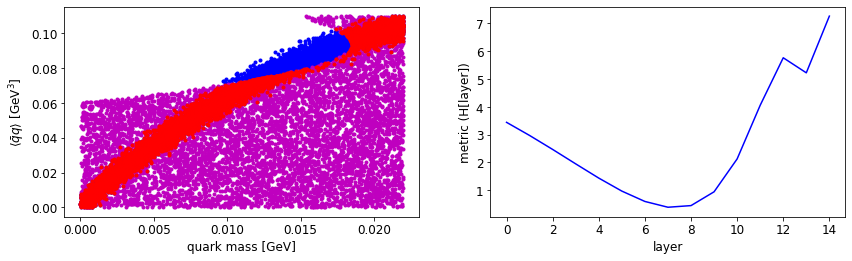

training epoch: 2100,   loss: 0.22067873179912567
lambda: -6.670344829559326,   AdS radius: 1.7849657535552979[1/GeV]
[3.4440117  2.9714124  2.4685943  1.9494917  1.4379593  0.97030497
 0.597504   0.38932702 0.44842875 0.94484174 2.1274981  4.057652
 5.7667828  5.2257175  7.26558   ]


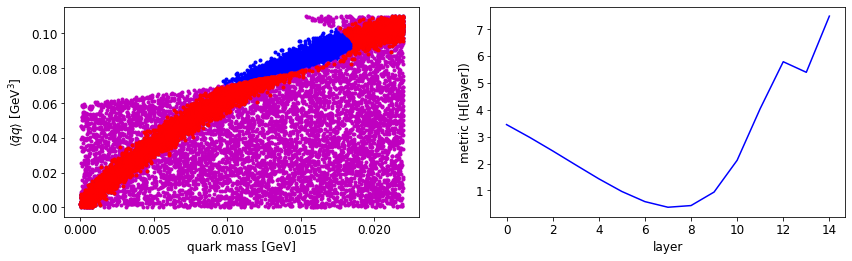

training epoch: 2200,   loss: 0.22004148364067078
lambda: -6.662392616271973,   AdS radius: 1.7833083868026733[1/GeV]
[3.4456062  2.9730015  2.46918    1.9479051  1.4330761  0.96148705
 0.58529496 0.3761132  0.43819982 0.93970174 2.120271   4.0384545
 5.780568   5.388204   7.4746604 ]


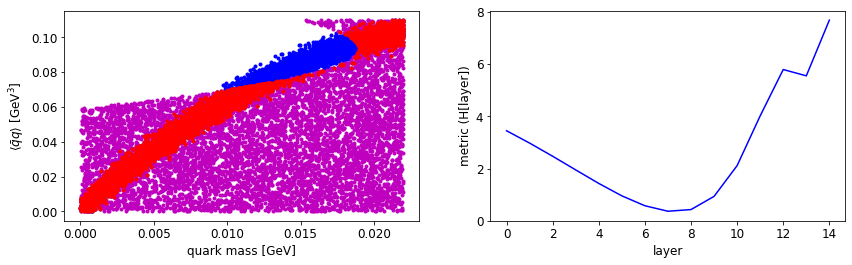

training epoch: 2300,   loss: 0.2200269252061844
lambda: -6.653838634490967,   AdS radius: 1.7819890975952148[1/GeV]
[3.4479287  2.9754336  2.4707818  1.9475032  1.4294736  0.9539332
 0.57416826 0.36361173 0.42808732 0.9339827  2.1122708  4.0192513
 5.794265   5.5519056  7.687268  ]


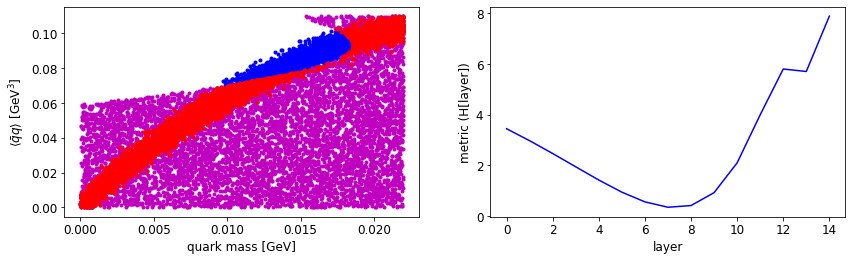

training epoch: 2400,   loss: 0.21962817013263702
lambda: -6.647874355316162,   AdS radius: 1.781365990638733[1/GeV]
[3.4483995  2.9761848  2.4708939  1.9458233  1.4248098  0.9454537
 0.5620808  0.34983477 0.41602945 0.9254775  2.1013484  3.998279
 5.8048544  5.707991   7.8926916 ]


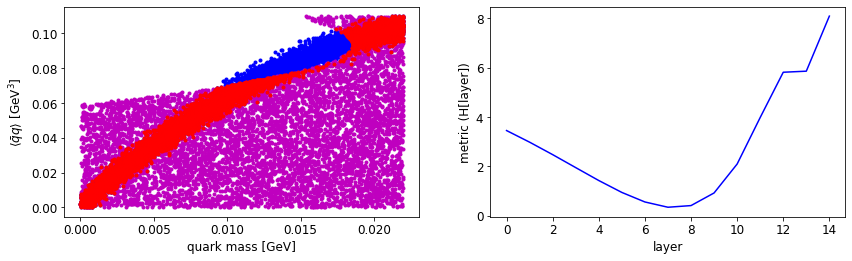

training epoch: 2500,   loss: 0.21946661174297333
lambda: -6.6409149169921875,   AdS radius: 1.7796406745910645[1/GeV]
[3.44983    2.9780002  2.4722488  1.9456215  1.4218616  0.9388738
 0.5519182  0.3377293  0.4050328  0.91725653 2.090617   3.9785743
 5.815315   5.858432   8.092548  ]


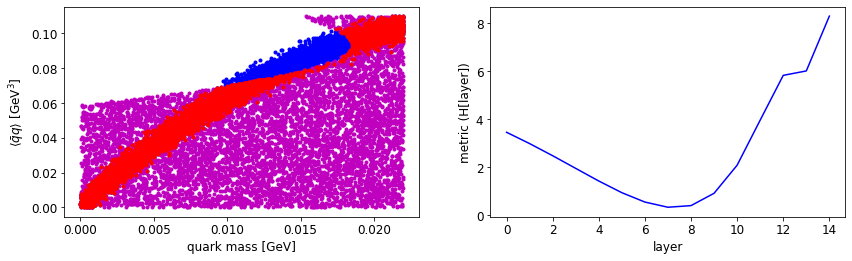

training epoch: 2600,   loss: 0.219338059425354
lambda: -6.633888244628906,   AdS radius: 1.7782776355743408[1/GeV]
[3.451437   2.9800968  2.474001   1.9459414  1.419534   0.9329222
 0.542241   0.32577246 0.39364237 0.9080161  2.0786312  3.9581802
 5.8251114  6.0090294  8.294861  ]


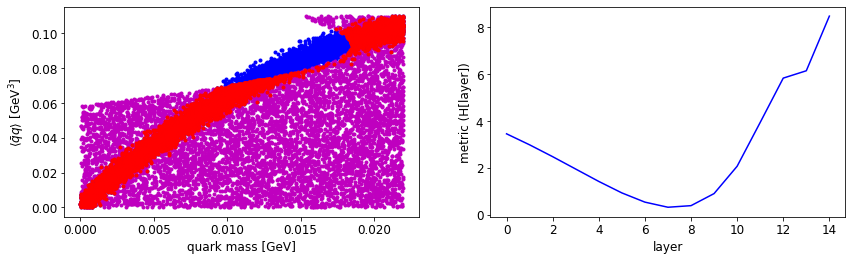

training epoch: 2700,   loss: 0.2189946472644806
lambda: -6.627952575683594,   AdS radius: 1.7764250040054321[1/GeV]
[3.4530058  2.9822204  2.475926   1.9466679  1.4179226  0.92800283
 0.5337886  0.31492946 0.38282198 0.8985853  2.0664427  3.9387348
 5.8332834  6.146955   8.482502  ]


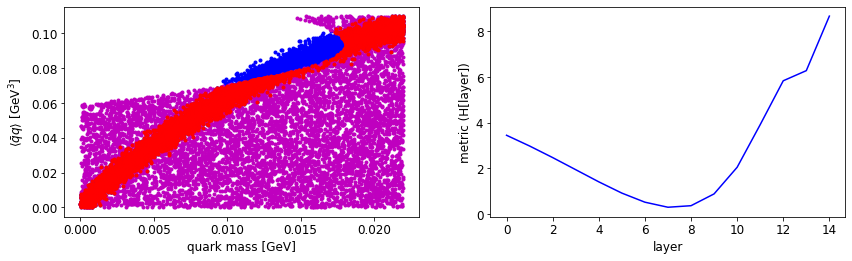

training epoch: 2800,   loss: 0.21887759864330292
lambda: -6.622139930725098,   AdS radius: 1.773309588432312[1/GeV]
[3.4537053  2.9836528  2.4772804  1.9469268  1.4159219  0.92270684
 0.52485204 0.30331132 0.3707375  0.88731647 2.0521634  3.9176092
 5.8396463  6.2827506  8.669667  ]


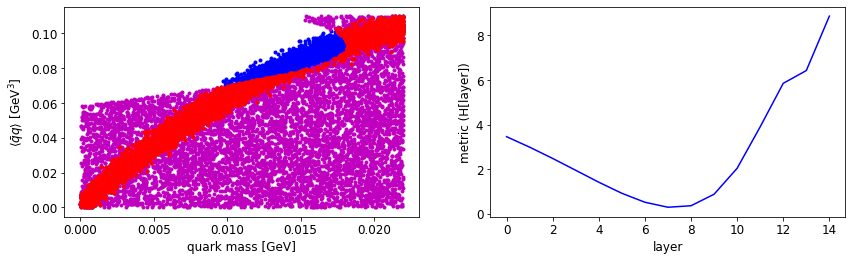

training epoch: 2900,   loss: 0.2189701497554779
lambda: -6.615806579589844,   AdS radius: 1.7729512453079224[1/GeV]
[3.4558313  2.9865599  2.4802518  1.9489541  1.4158102  0.91936404
 0.51780754 0.29334664 0.3598613  0.8767283  2.0383985  3.8975222
 5.8469377  6.4187107  8.858844  ]


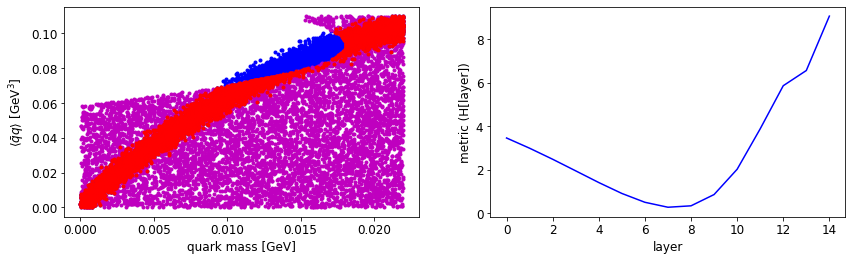

training epoch: 3000,   loss: 0.2185852974653244
lambda: -6.609778881072998,   AdS radius: 1.770877480506897[1/GeV]
[3.4573588  2.9889038  2.4827714  1.9507053  1.41562    0.9161083
 0.5109119  0.28339028 0.3486008  0.8652537  2.0236475  3.877086
 5.8530803  6.54941    9.043154  ]


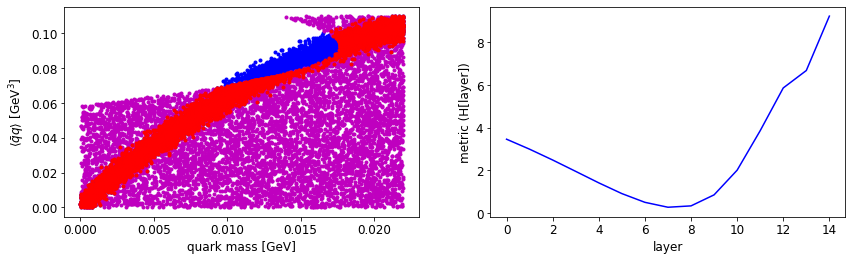

training epoch: 3100,   loss: 0.21833236515522003
lambda: -6.605630397796631,   AdS radius: 1.7734686136245728[1/GeV]
[3.4581997  2.9905508  2.4846413  1.9519286  1.4150938  0.9127149
 0.5039994  0.2733561  0.33695024 0.85296506 2.0080957  3.8565578
 5.858089   6.673321   9.220614  ]


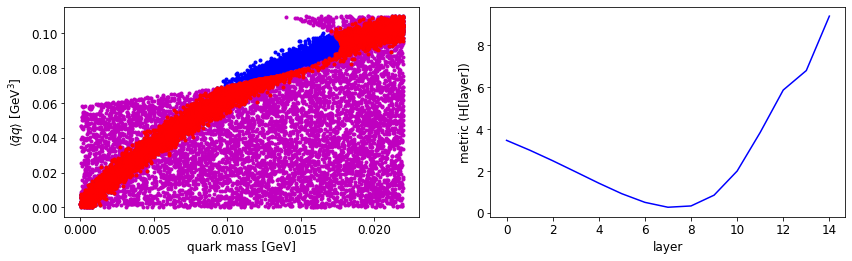

training epoch: 3200,   loss: 0.21824148297309875
lambda: -6.599495887756348,   AdS radius: 1.7698999643325806[1/GeV]
[3.4599574  2.993157   2.4875453  1.954314   1.415903   0.9108336
 0.4986962  0.26485518 0.3265274  0.84148586 1.993253   3.8371975
 5.863299   6.792773   9.393449  ]


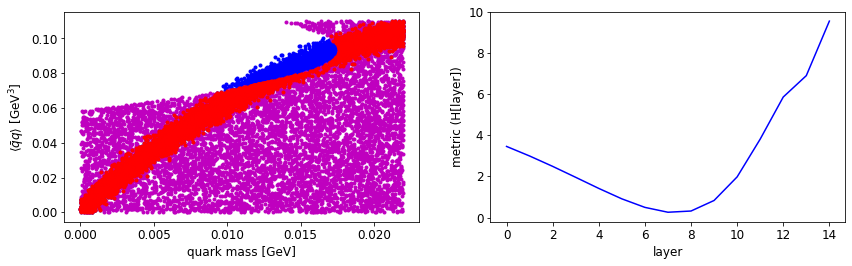

training epoch: 3300,   loss: 0.21830539405345917
lambda: -6.593994617462158,   AdS radius: 1.767748236656189[1/GeV]
[3.4614449  2.9955409  2.4902756  1.956599   1.4167061  0.9090329
 0.49349377 0.25632668 0.31576318 0.82926375 1.9775382  3.8173177
 5.8675866  6.9088473  9.563856  ]


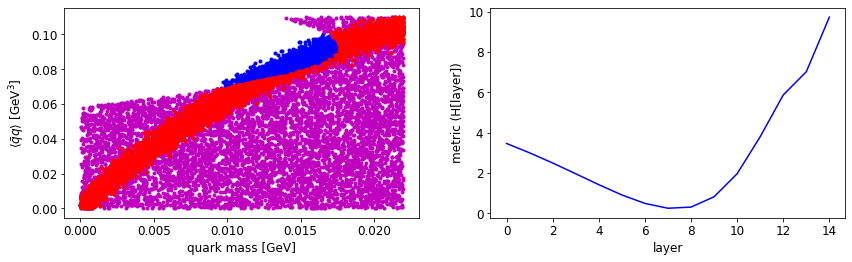

training epoch: 3400,   loss: 0.21807856857776642
lambda: -6.58883810043335,   AdS radius: 1.7698012590408325[1/GeV]
[3.4635282  2.9985678  2.4937067  1.9596444  1.4183354  0.9081098
 0.48915032 0.24850306 0.30538273 0.8170318  1.9616573  3.7975826
 5.871865   7.0235114  9.734265  ]


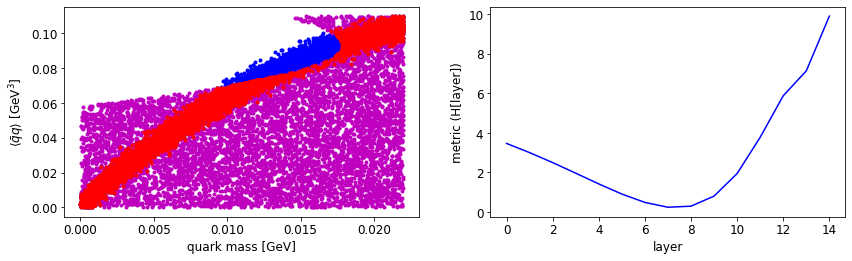

training epoch: 3500,   loss: 0.21781837940216064
lambda: -6.582767009735107,   AdS radius: 1.7658414840698242[1/GeV]
[3.4656792  3.0017312  2.4973712  1.9630543  1.420474   0.9078431
 0.48555657 0.24138533 0.29547206 0.8049315  1.9458077  3.778183
 5.875648   7.1333404  9.89945   ]


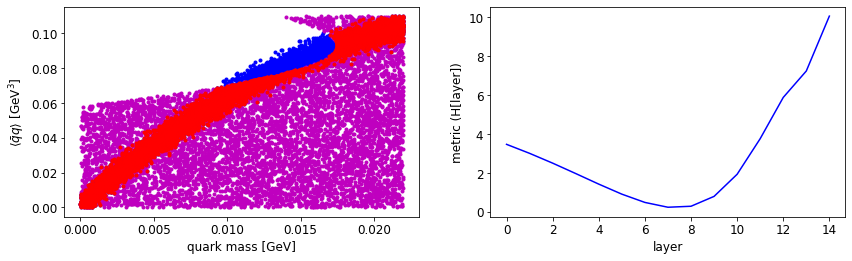

training epoch: 3600,   loss: 0.21763674914836884
lambda: -6.578775405883789,   AdS radius: 1.7649880647659302[1/GeV]
[ 3.4666312   3.0036912   2.4998586   1.9653388   1.4215915   0.90667844
  0.48115933  0.23344812  0.28455466  0.7915445   1.9286324   3.7577925
  5.8775015   7.2363124  10.057078  ]


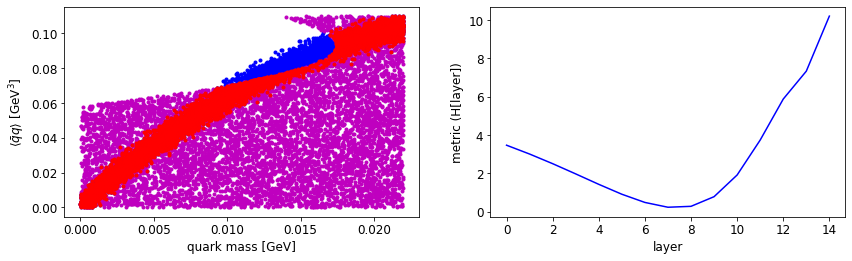

training epoch: 3700,   loss: 0.21759334206581116
lambda: -6.5736002922058105,   AdS radius: 1.7634520530700684[1/GeV]
[ 3.4683254   3.006457    2.503224    1.968599    1.4237775   0.9066609
  0.47793773  0.22660427  0.27450058  0.77872     1.9119009   3.7380831
  5.8798313   7.3379188  10.214264  ]


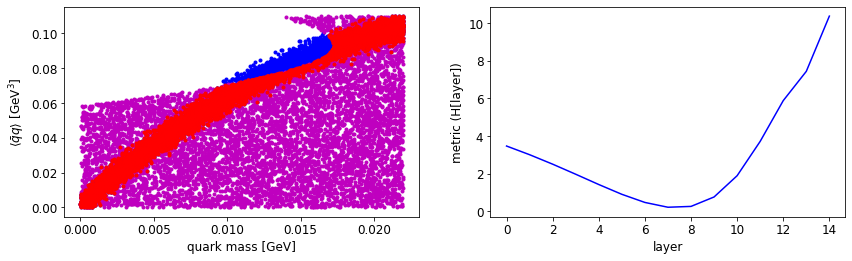

training epoch: 3800,   loss: 0.21745622158050537
lambda: -6.568746566772461,   AdS radius: 1.7600098848342896[1/GeV]
[ 3.4696658   3.0088944   2.5063019   1.9716259   1.4258057   0.9065578
  0.47465408  0.2196183   0.26407424  0.7652013   1.8943036   3.7176185
  5.8807826   7.4351177  10.367018  ]


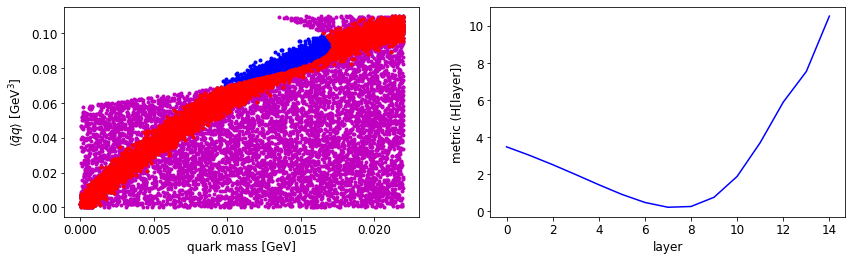

training epoch: 3900,   loss: 0.21733441948890686
lambda: -6.564333438873291,   AdS radius: 1.7607452869415283[1/GeV]
[ 3.4714413   3.0118332   2.5099745   1.9753205   1.428553    0.90720206
  0.47208667  0.21321012  0.2539608   0.75167394  1.8765252   3.6971538
  5.8819466   7.5325747  10.522285  ]


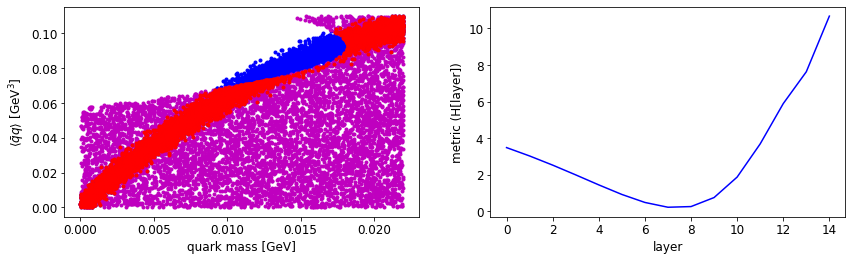

training epoch: 4000,   loss: 0.21737878024578094
lambda: -6.5573530197143555,   AdS radius: 1.7605892419815063[1/GeV]
[ 3.47608     3.0176413   2.5165203   1.9819473   1.434315    0.91093755
  0.47265384  0.20988846  0.24674511  0.7407648   1.8612139   3.6792397
  5.8849516   7.628478   10.675726  ]


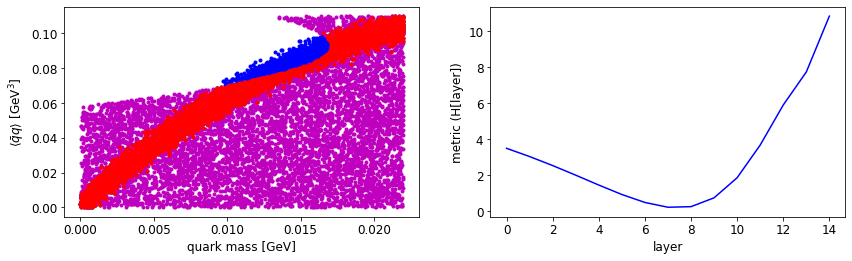

training epoch: 4100,   loss: 0.2171931266784668
lambda: -6.555666923522949,   AdS radius: 1.7598185539245605[1/GeV]
[ 3.47523     3.0180044   2.5176864   1.983263    1.4348578   0.9095623
  0.4681912   0.20154281  0.23438932  0.7245244   1.8405286   3.6561344
  5.882185    7.7151756  10.819759  ]


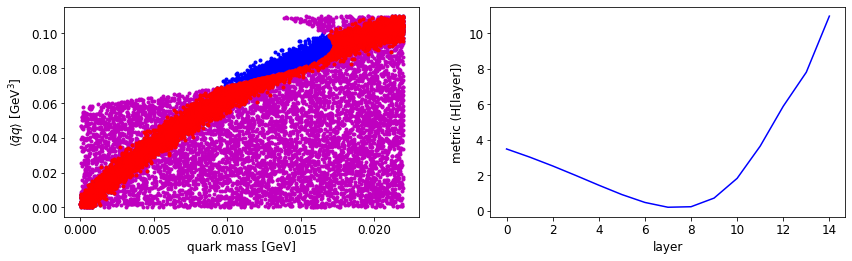

training epoch: 4200,   loss: 0.2171001136302948
lambda: -6.551389217376709,   AdS radius: 1.7566492557525635[1/GeV]
[ 3.4774768   3.021471    2.5219784   1.9877657   1.4386992   0.9116493
  0.46738744  0.19701432  0.22589971  0.7121144   1.8237458   3.6370661
  5.8818145   7.7969556  10.955783  ]


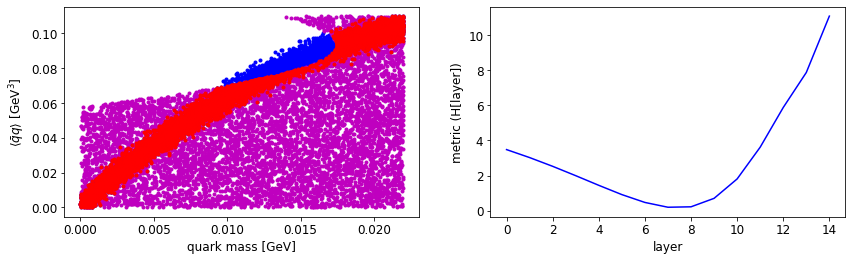

training epoch: 4300,   loss: 0.21700377762317657
lambda: -6.546450614929199,   AdS radius: 1.754417061805725[1/GeV]
[ 3.4798331   3.0250585   2.526434    1.9924917   1.4428294   0.9140722
  0.46692535  0.19275734  0.21751083  0.69957757  1.8067003   3.6178253
  5.8811946   7.877495   11.091642  ]


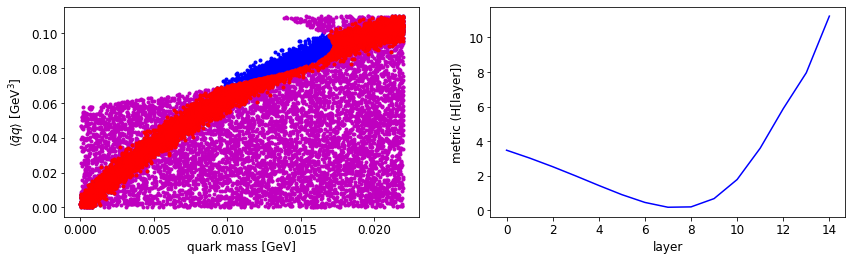

training epoch: 4400,   loss: 0.21689870953559875
lambda: -6.543926239013672,   AdS radius: 1.7552614212036133[1/GeV]
[ 3.4812522   3.0276613   2.52991     1.9962842   1.446081    0.9156836
  0.46569493  0.18771386  0.20822398  0.68597066  1.7885067   3.5975235
  5.8791323   7.954381   11.224094  ]


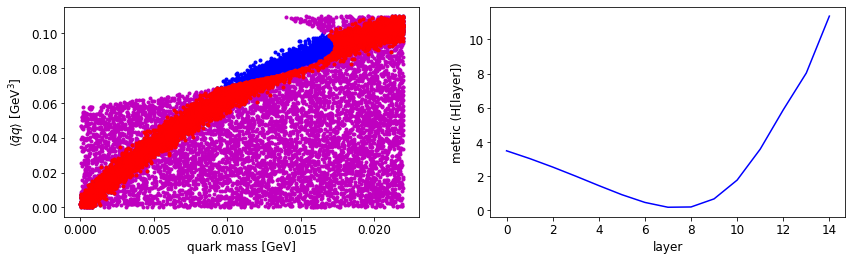

training epoch: 4500,   loss: 0.21703143417835236
lambda: -6.539891242980957,   AdS radius: 1.75425124168396[1/GeV]
[ 3.4834213   3.0310917   2.5342805   2.0010316   1.4503646   0.9183752
  0.46555096  0.18368162  0.19977076  0.6729547   1.7707365   3.5776722
  5.8774586   8.030759   11.356954  ]


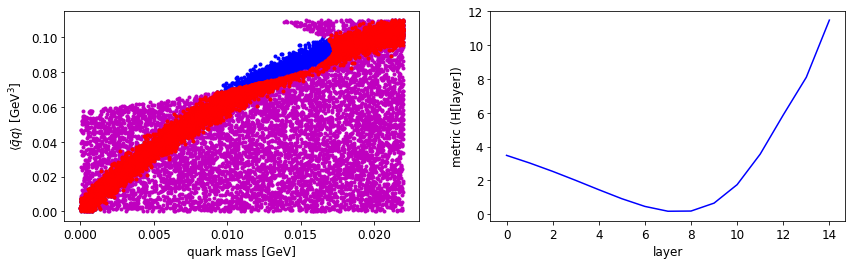

training epoch: 4600,   loss: 0.21705909073352814
lambda: -6.5369768142700195,   AdS radius: 1.7534024715423584[1/GeV]
[ 3.4848256   3.0337315   2.537876    2.0050676   1.4540336   0.92058104
  0.4650474   0.17937927  0.19106214  0.6596485   1.7527298   3.557749
  5.8751154   8.103139   11.485212  ]


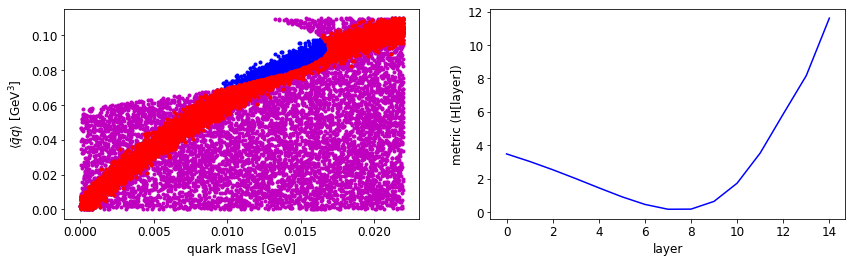

training epoch: 4700,   loss: 0.21679966151714325
lambda: -6.534080982208252,   AdS radius: 1.752258062362671[1/GeV]
[ 3.4858046   3.0358865   2.5409756   2.0086367   1.4572943   0.92244345
  0.46424803  0.17477119  0.18195349  0.6457932   1.7340904   3.5372617
  5.8719554   8.173095   11.611495  ]


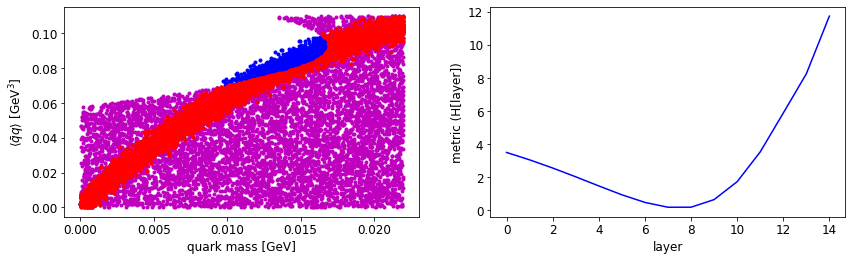

training epoch: 4800,   loss: 0.2168962061405182
lambda: -6.530371189117432,   AdS radius: 1.7507431507110596[1/GeV]
[ 3.4876974   3.0390382   2.5450964   2.0132542   1.4616326   0.9254234
  0.4645732   0.1712275   0.17375611  0.6326292   1.7159678   3.517261
  5.8691344   8.2424     11.738035  ]


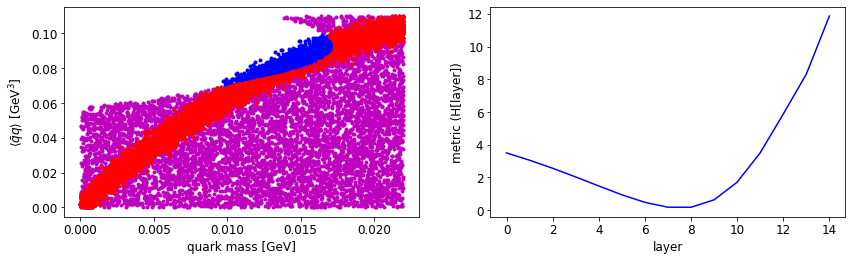

training epoch: 4900,   loss: 0.21655383706092834
lambda: -6.526182174682617,   AdS radius: 1.751014232635498[1/GeV]
[ 3.4905698   3.0431411   2.5501797   2.0188406   1.4669894   0.9294869
  0.46605688  0.16888799  0.16674349  0.62058055  1.698944    3.498414
  5.866913    8.309458   11.86161   ]


In [22]:
total_epoch=5000
show_epoch_each=100

for epoch in range(total_epoch):
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_Pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
        # calclation of loss
        loss = Test.loss(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
        # update
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
        print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

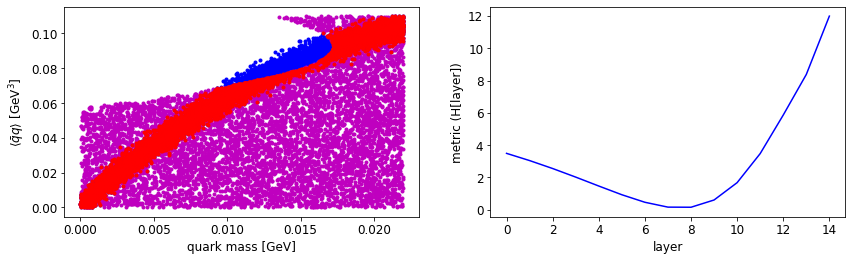

training epoch: 0,   loss: 0.21650207042694092
lambda: -6.523227214813232,   AdS radius: 1.7510930299758911[1/GeV]
[ 3.492089    3.0459046   2.5539656   2.0232043   1.471181    0.9324523
  0.46648827  0.16548611  0.15858033  0.6072414   1.6805478   3.4782662
  5.8633394   8.374267   11.983737  ]


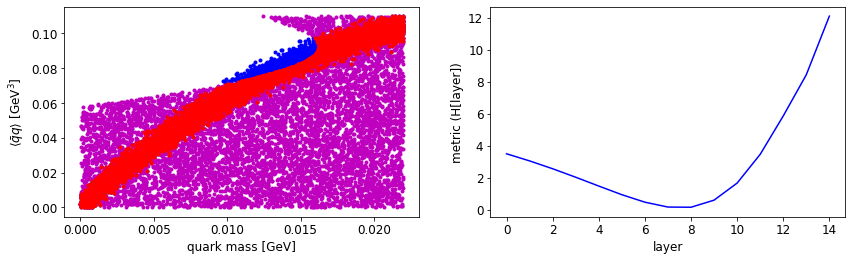

training epoch: 100,   loss: 0.21666550636291504
lambda: -6.5221943855285645,   AdS radius: 1.7496031522750854[1/GeV]
[ 3.4910872   3.0461416   2.555237    2.0250895   1.4729722   0.933107
  0.46470577  0.15993945  0.148283    0.5917343   1.6599959   3.456053
  5.857295    8.434189   12.100415  ]


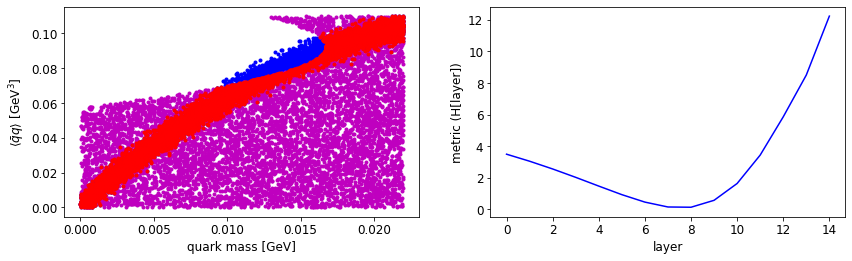

training epoch: 200,   loss: 0.21639125049114227
lambda: -6.517837047576904,   AdS radius: 1.7497609853744507[1/GeV]
[ 3.4940488   3.0502505   2.5603456   2.0308342   1.478669    0.9377446
  0.4669857   0.15851349  0.14211096  0.5803144   1.6435393   3.4380155
  5.855098    8.495958   12.218812  ]


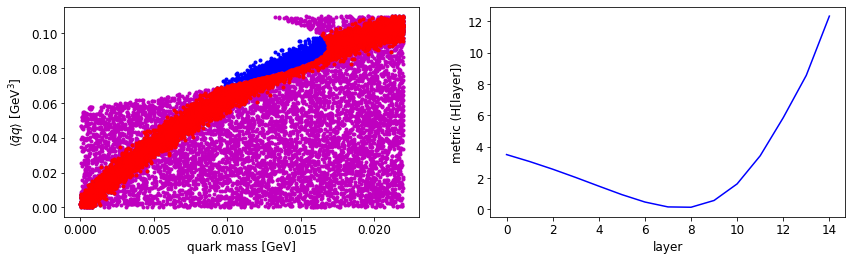

training epoch: 300,   loss: 0.21634554862976074
lambda: -6.5137939453125,   AdS radius: 1.7473269701004028[1/GeV]
[ 3.496089    3.053462    2.5645556   2.0356667   1.4834908   0.9415691
  0.46852374  0.15639445  0.13524006  0.5681378   1.6262826   3.4191475
  5.851567    8.554262   12.333371  ]


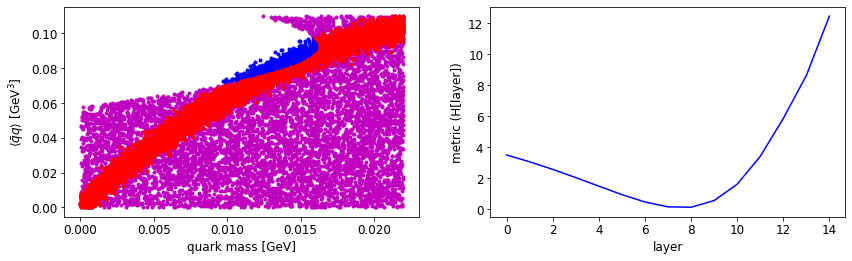

training epoch: 400,   loss: 0.21634188294410706
lambda: -6.51217794418335,   AdS radius: 1.7463778257369995[1/GeV]
[ 3.4961877   3.0547087   2.5667865   2.0385494   1.4863967   0.94353783
  0.46828568  0.15256643  0.12668587  0.5542694   1.6073544   3.398678
  5.8460994   8.60871    12.443881  ]


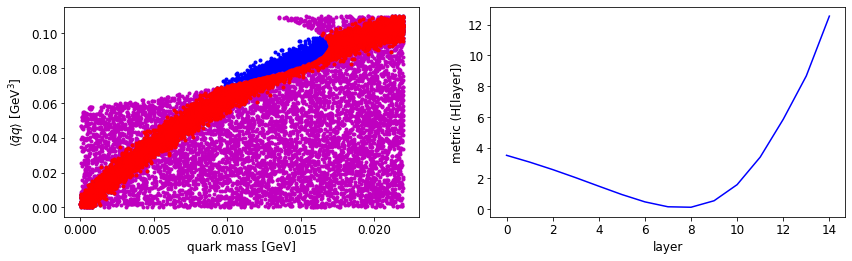

training epoch: 500,   loss: 0.21640031039714813
lambda: -6.507534027099609,   AdS radius: 1.7448973655700684[1/GeV]
[ 3.4993494   3.0590134   2.5720944   2.0445204   1.4924413   0.9487213
  0.47135207  0.15212636  0.12156729  0.5438492   1.5919154   3.3817635
  5.843829    8.664329   12.554873  ]


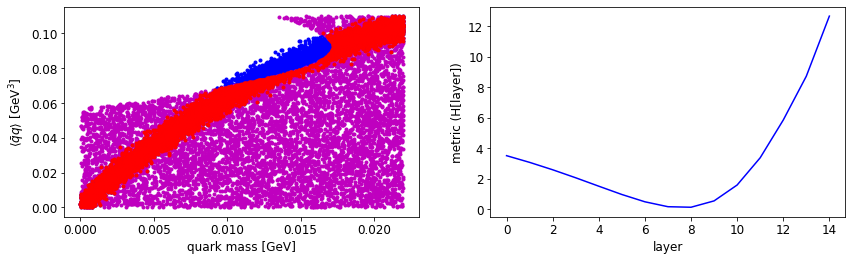

training epoch: 600,   loss: 0.21619653701782227
lambda: -6.50393533706665,   AdS radius: 1.7462047338485718[1/GeV]
[ 3.5015242   3.062298    2.5763588   2.0494595   1.4974742   0.9529215
  0.4734625   0.15072092  0.1154176   0.5322899   1.5752665   3.3636894
  5.840426    8.718311   12.665152  ]


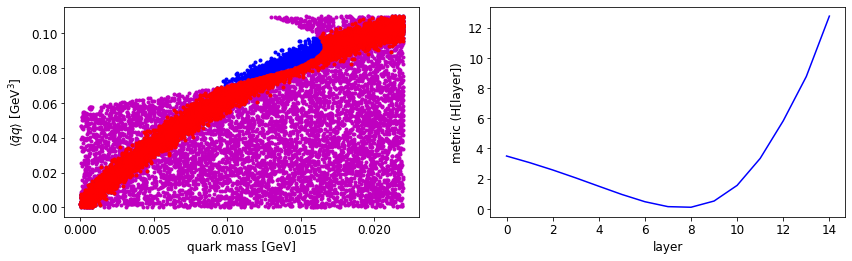

training epoch: 700,   loss: 0.21617849171161652
lambda: -6.50175666809082,   AdS radius: 1.743434190750122[1/GeV]
[ 3.5014517   3.063348    2.5784001   2.052187    1.500325    0.95499265
  0.4734979   0.14727879  0.10722008  0.518623    1.5564518   3.3433967
  5.8344502   8.768178   12.771088  ]


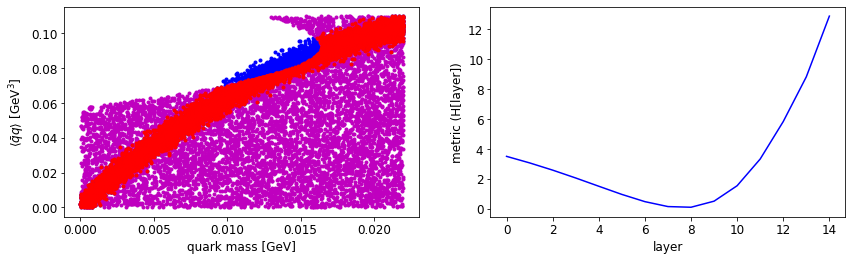

training epoch: 800,   loss: 0.2162626087665558
lambda: -6.498924255371094,   AdS radius: 1.7442326545715332[1/GeV]
[ 3.5025182   3.0655284   2.5815835   2.0560794   1.5043774   0.95829946
  0.47479615  0.14509012  0.10021049  0.5060364   1.5386446   3.3241951
  5.8297005   8.819164   12.879472  ]


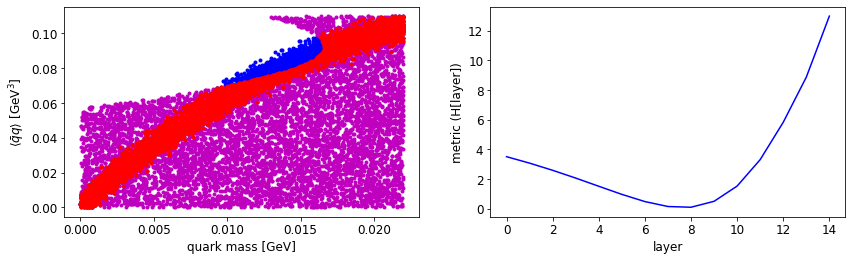

training epoch: 900,   loss: 0.2161511927843094
lambda: -6.49498987197876,   AdS radius: 1.744031548500061[1/GeV]
[ 3.5044847   3.0685678   2.585592    2.06079     1.5092646   0.9624976
  0.47706777  0.14396882  0.09434438  0.49463865  1.5220698   3.3062284
  5.8256674   8.868599   12.985186  ]


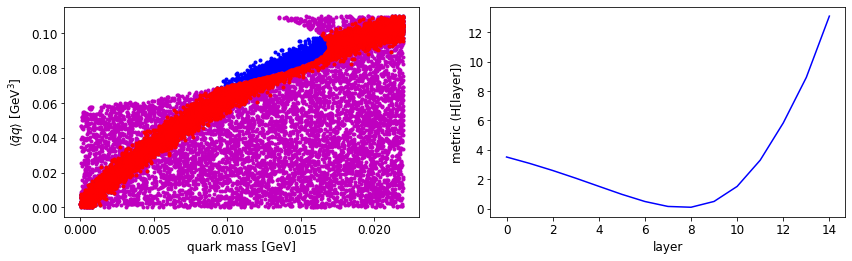

training epoch: 1000,   loss: 0.2162613868713379
lambda: -6.490087032318115,   AdS radius: 1.740756869316101[1/GeV]
[ 3.5064251   3.0715723   2.5895963   2.0655384   1.5142442   0.9668639
  0.479602    0.1432042   0.08890367  0.4837067   1.5060171   3.28886
  5.82202     8.916934   13.089538  ]


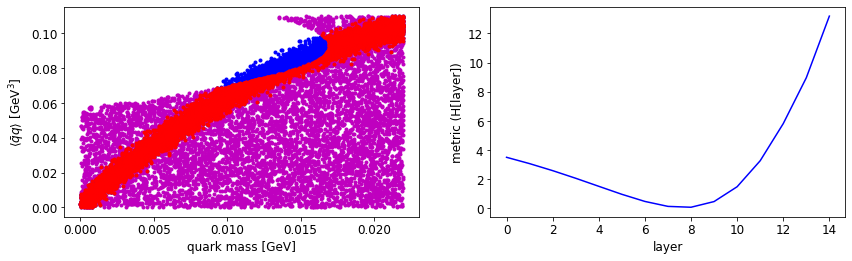

training epoch: 1100,   loss: 0.21617968380451202
lambda: -6.48649787902832,   AdS radius: 1.7404327392578125[1/GeV]
[ 3.507914    3.0740697   2.5930152   2.0696547   1.5185878   0.97063154
  0.4816217   0.14204422  0.08319534  0.47262448  1.4899282   3.2715087
  5.817829    8.962361   13.189627  ]


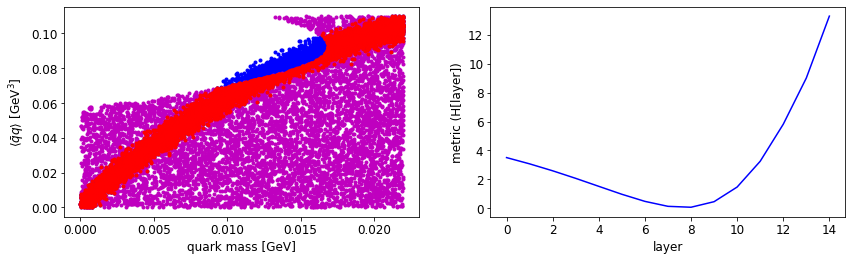

training epoch: 1200,   loss: 0.21610519289970398
lambda: -6.483421325683594,   AdS radius: 1.740020751953125[1/GeV]
[ 3.5090122   3.0761528   2.5960042   2.073336    1.5225112   0.9740183
  0.4833211   0.14062993  0.07728387  0.46136525  1.4736916   3.2540164
  5.813176    9.005829   13.287129  ]


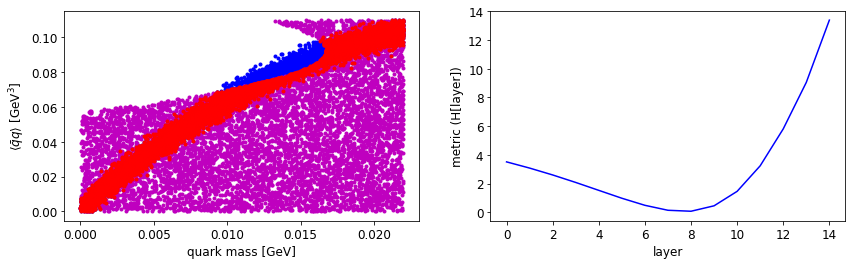

training epoch: 1300,   loss: 0.21608082950115204
lambda: -6.480369567871094,   AdS radius: 1.7398912906646729[1/GeV]
[ 3.5099242   3.0780673   2.5988324   2.0768611   1.5262889   0.97728914
  0.48494682  0.13917984  0.07134695  0.45005995  1.4573883   3.2364771
  5.8083444   9.048219   13.383679  ]


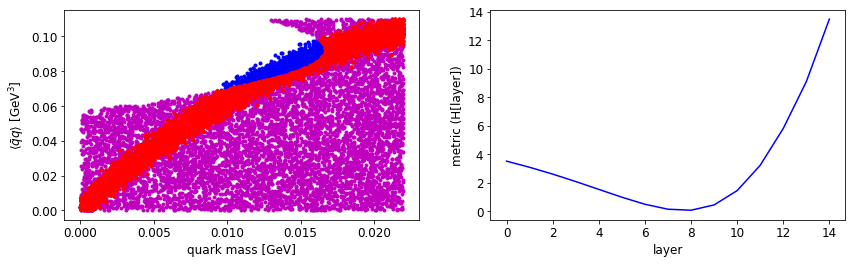

training epoch: 1400,   loss: 0.21588662266731262
lambda: -6.47723913192749,   AdS radius: 1.7405164241790771[1/GeV]
[ 3.5112498   3.080362    2.6020124   2.0807061   1.5303751   0.98086786
  0.48688918  0.13804896  0.0657004   0.43897435  1.4412218   3.2189858
  5.803271    9.089379   13.478799  ]


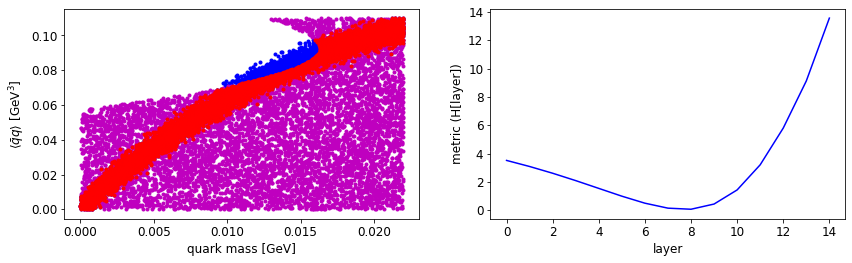

training epoch: 1500,   loss: 0.21601314842700958
lambda: -6.4739603996276855,   AdS radius: 1.7379486560821533[1/GeV]
[ 3.511385    3.0814788   2.604053    2.0834646   1.5334287   0.9834858
  0.4879751   0.13618703  0.05945407  0.42741397  1.4247118   3.2012618
  5.797717    9.128606   13.571357  ]


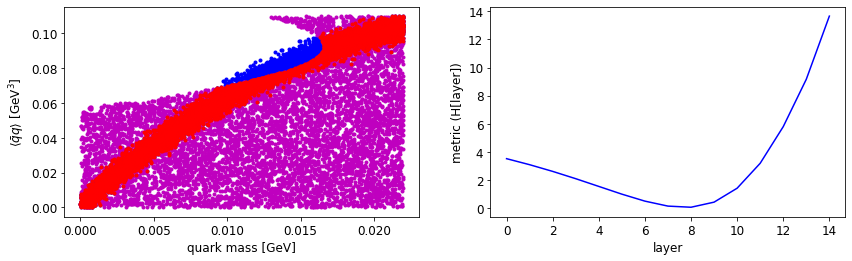

training epoch: 1600,   loss: 0.21584808826446533
lambda: -6.4701247215271,   AdS radius: 1.7385354042053223[1/GeV]
[ 3.5134459   3.0844586   2.6079047   2.0879982   1.5382376   0.9878689
  0.4908613   0.13618165  0.05512199  0.4178091   1.4101852   3.1854963
  5.7937446   9.167864   13.6630125 ]


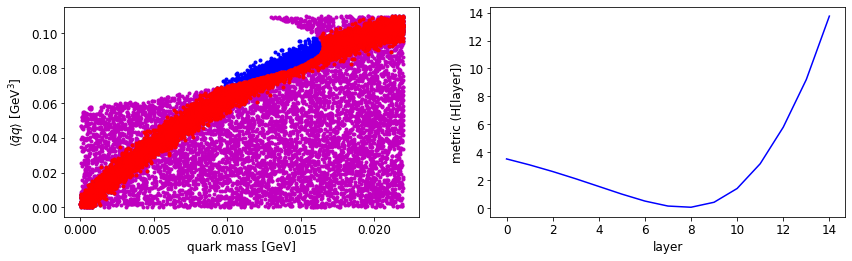

training epoch: 1700,   loss: 0.21578049659729004
lambda: -6.4666829109191895,   AdS radius: 1.7375102043151855[1/GeV]
[ 3.5146005   3.086577    2.610905    2.091689    1.5422163   0.99142796
  0.49291882  0.13531554  0.04984706  0.4071261   1.3944356   3.1684139
  5.788405    9.205643   13.7540045 ]


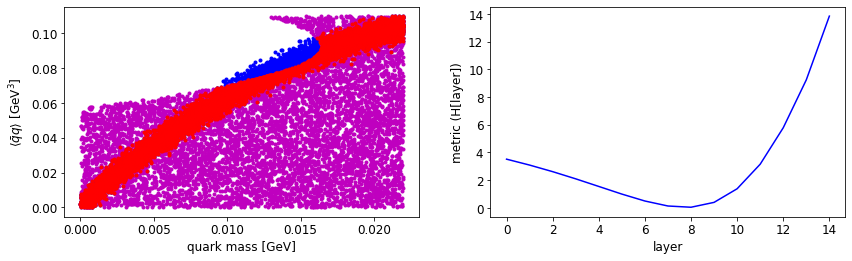

training epoch: 1800,   loss: 0.2158893346786499
lambda: -6.463499069213867,   AdS radius: 1.7364182472229004[1/GeV]
[ 3.5155141   3.0884573   2.6136737   2.095143    1.545973    0.9947992
  0.49485278  0.13441935  0.04464848  0.39662147  1.3789521   3.151624
  5.782988    9.241751   13.842351  ]


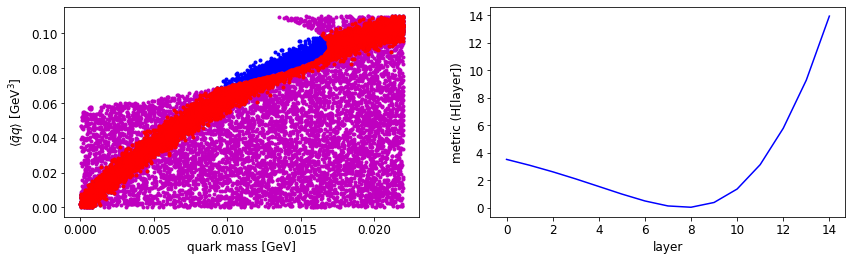

training epoch: 1900,   loss: 0.21583768725395203
lambda: -6.458526134490967,   AdS radius: 1.7339274883270264[1/GeV]
[ 3.5178123   3.0917087   2.6178145   2.099992    1.5511423   0.999622
  0.4982976   0.135113    0.04112378  0.38786379  1.3652761   3.1366572
  5.7790837   9.278075   13.930118  ]


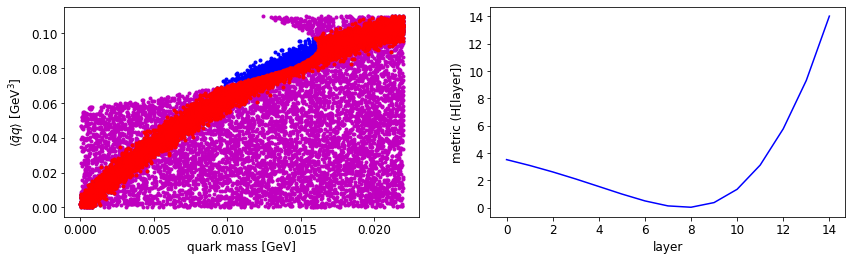

training epoch: 2000,   loss: 0.21576562523841858
lambda: -6.457292556762695,   AdS radius: 1.7360235452651978[1/GeV]
[ 3.5175767   3.09239     2.6193445   2.102186    1.553624    1.0017319
  0.49900064  0.1330199   0.0347354   0.37612545  1.3484899   3.1184874
  5.771873    9.310773   14.014652  ]


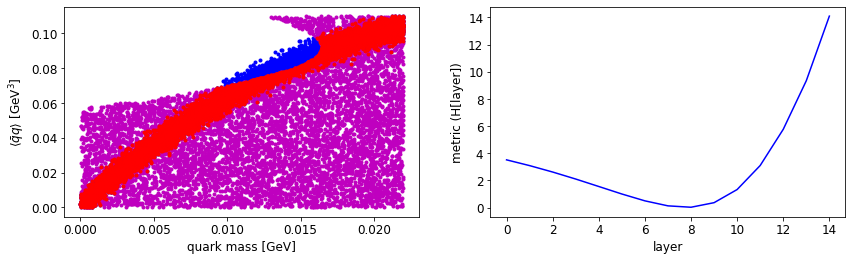

training epoch: 2100,   loss: 0.21568827331066132
lambda: -6.453540325164795,   AdS radius: 1.7365363836288452[1/GeV]
[ 3.5192175   3.094969    2.6228025   2.1063433   1.5581083   1.0058975
  0.50183696  0.13315862  0.03069171  0.3668429   1.3342686   3.102944
  5.7670426   9.344583   14.099385  ]


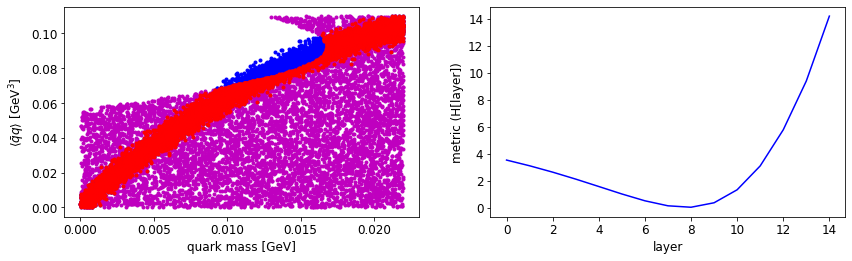

training epoch: 2200,   loss: 0.21566462516784668
lambda: -6.449235916137695,   AdS radius: 1.7365936040878296[1/GeV]
[ 3.5213492   3.097994    2.6266816   2.1109126   1.5630167   1.0105008
  0.50512516  0.13376608  0.02711438  0.35799664  1.3204366   3.0877264
  5.7623763   9.377903   14.18357   ]


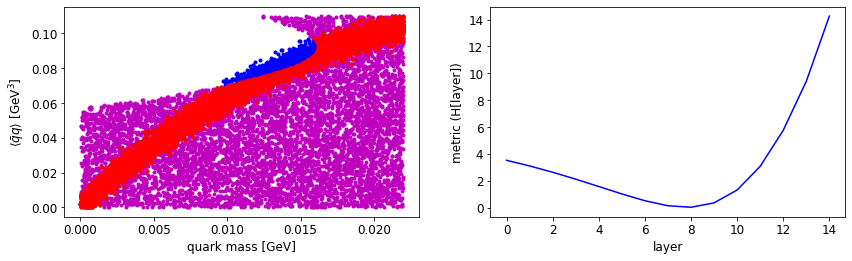

training epoch: 2300,   loss: 0.21564587950706482
lambda: -6.447081565856934,   AdS radius: 1.7355822324752808[1/GeV]
[ 3.52086     3.0983977   2.6279438   2.1128807   1.56534     1.0125551
  0.5059316   0.13198586  0.02126363  0.34699407  1.3045518   3.070497
  5.7553687   9.407543   14.263058  ]


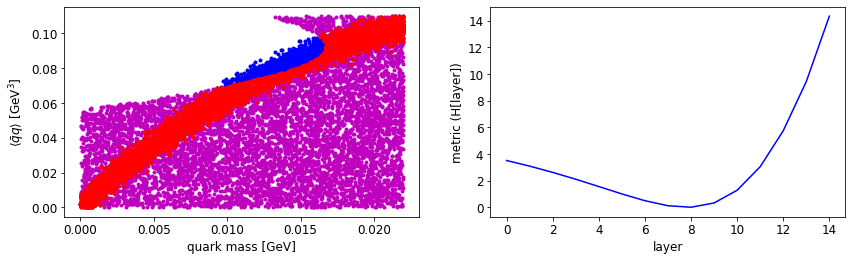

training epoch: 2400,   loss: 0.21582981944084167
lambda: -6.442010879516602,   AdS radius: 1.7337833642959595[1/GeV]
[ 3.523269    3.1016507   2.632031    2.117676    1.5705134   1.0175012
  0.5096873   0.13323677  0.018541    0.33921596  1.291978    3.0566065
  5.7514353   9.439187   14.343798  ]


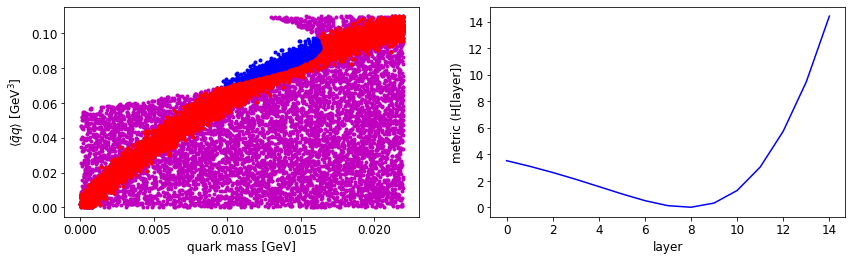

training epoch: 2500,   loss: 0.215539813041687
lambda: -6.438985347747803,   AdS radius: 1.7345547676086426[1/GeV]
[3.5240655e+00 3.1032915e+00 2.6344671e+00 2.1207657e+00 1.5739464e+00
 1.0207059e+00 5.1173019e-01 1.3283518e-01 1.4251181e-02 3.2996216e-01
 1.2779951e+00 3.0412865e+00 5.7456837e+00 9.4676132e+00 1.4420113e+01]


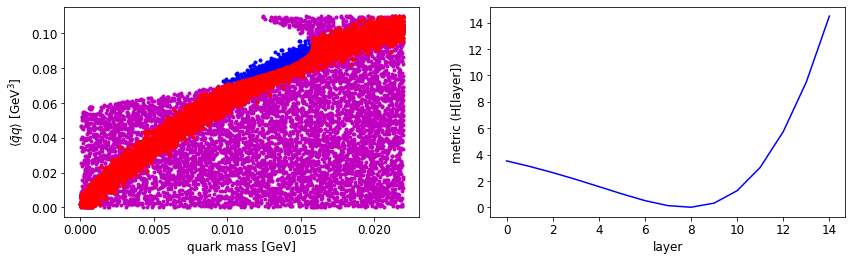

training epoch: 2600,   loss: 0.2157493382692337
lambda: -6.437347412109375,   AdS radius: 1.7330667972564697[1/GeV]
[3.5229928e+00 3.1030729e+00 2.6350572e+00 2.1220186e+00 1.5755649e+00
 1.0221151e+00 5.1200622e-01 1.3069011e-01 8.2273604e-03 3.1895936e-01
 1.2622304e+00 3.0241358e+00 5.7379432e+00 9.4935169e+00 1.4493842e+01]


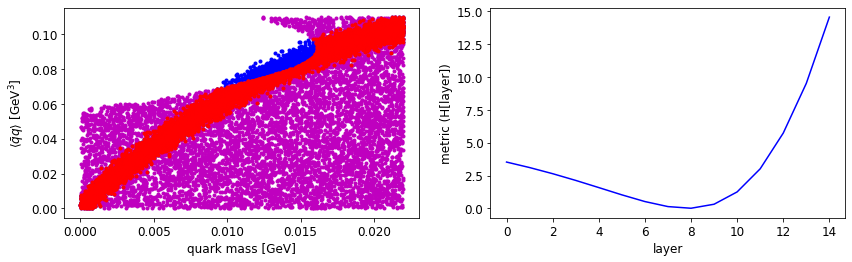

training epoch: 2700,   loss: 0.21573610603809357
lambda: -6.433019638061523,   AdS radius: 1.734542965888977[1/GeV]
[3.5249364e+00 3.1058226e+00 2.6386161e+00 2.1262727e+00 1.5802062e+00
 1.0265787e+00 5.1536882e-01 1.3165957e-01 5.3317011e-03 3.1108388e-01
 1.2496041e+00 3.0102077e+00 5.7335749e+00 9.5228710e+00 1.4571704e+01]


In [ ]:
total_epoch=5000
show_epoch_each=100

for epoch in range(total_epoch):
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_Pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
        # calclation of loss
        loss = Test.loss(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
        # update
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
        print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

In [23]:
print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

[ 3.4904976   3.0443182   2.5523782   2.021618    1.4696027   0.9308912
  0.46495643  0.1639956   0.15713984  0.60585433  1.679212    3.476947
  5.8618546   8.372107   11.981003  ]


# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [ ]:
%%bash
mkdir trained_models

Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [ ]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [ ]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [ ]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

In [ ]:
model.lamb.weight.data.numpy() # lambda

In [ ]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)